In [1]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeVigoV2
from matplotlib import pyplot as plt
import os
import sys
import numpy as np

sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "pauli_lindblad_per"))

from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")

In [2]:
backend = FakeVigoV2()

In [3]:
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(2*n)
    trotterLayer.rx(dt*4*h, range(2*n))
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [2*i+1 for i in range(n)])
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [2*i+2 for i in range(n-1)])
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .2
n = 2

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(n*2)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    transpiled = transpile(trotterCircuit, backend)
    return transpiled

circuits = [maketrotterCircuit(i) for i in range(1,15)]

In [4]:
def executor(circuits):
    return backend.run(circuits).result().get_counts()

In [5]:
experiment = tomography(circuits = circuits, inst_map = [0,1,2,3,4], backend = backend)

In [6]:
experiment.generate(samples = 32, single_samples = 200, depths = [2,4,8,16])

In [7]:
experiment.run(executor)

In [8]:
noisedataframe = experiment.analyze()

In [9]:
perexp = experiment.create_per_experiment(circuits)

In [10]:
noise_strengths = [0,0.5,1,2]
expectations = ["ZIIII","IZIII","IIZII","IIIZI"]
perexp.generate(expectations = expectations, samples = 500, noise_strengths = noise_strengths)

## PER

In [40]:
perexp.run(executor)

In [41]:
circuit_results = perexp.analyze()

In [42]:
results = []
results_errors = []
results_at_noise = []
results_at_noise_errors = []
for run in circuit_results:
    tot = 0
    tot_error = [0,0]
    tot_at_noise = [0 for _ in range(len(noise_strengths))]
    tot_at_noise_errors = [0 for _ in range(len(noise_strengths))]
    for op in expectations:
        #get the full per results
        expec = run.get_result(op).expectation
        tot += expec

        #get the corresponding fit-errors
        expec_error = run.get_result(op).expectation_error
        for i in range(0,len(tot_error)):
            tot_error[i] += expec_error[i]/len(expectations)

        #get the value at the different noise levels
        expec_at_noise = run.get_result(op).get_expectations()
        for i in range(0,len(tot_at_noise)):
            tot_at_noise[i] += expec_at_noise[i]/len(expectations)

        expec_at_noise_error = [run.get_result(op).get_std_of_strengths(strength) for strength in noise_strengths]
        for i in range(0,len(tot_at_noise)):
            tot_at_noise_errors[i] += expec_at_noise_error[i]/len(expectations)

        

    results.append(tot/len(expectations))
    results_errors.append(tot_error)
    results_at_noise.append(tot_at_noise)
    results_at_noise_errors.append(tot_at_noise_errors)

In [43]:
results_at_noise[0]

[0.7721304694486697,
 0.7277049328485531,
 0.6752440433719226,
 0.6728260120655503]

In [44]:
for run in circuit_results:
    print(run.get_result(expectations[0]).get_strengths(), run.get_result(expectations[0]).get_expectations())

[0, 0.5, 1, 2] [0.7402730774877456, 0.7268852025764966, 0.7043843683896546, 0.6520745325247147]
[0, 0.5, 1, 2] [-0.017221093918690727, -0.026208282880628177, -0.03966586934138758, -0.03057314603523112]
[0, 0.5, 1, 2] [-0.9635918892494976, -0.8170836921356522, -0.6701752798613706, -0.6618424056846265]
[0, 0.5, 1, 2] [-0.447571590971392, -1.1597420359748336, -0.8930891346965729, -0.8899314647163216]
[0, 0.5, 1, 2] [-0.3056244287839289, -0.32507498397558027, -0.5318636136470721, -0.5538637633779379]
[0, 0.5, 1, 2] [0.0, 0.1043637707029884, 0.06633092589879419, 0.29357858010401927]
[0, 0.5, 1, 2] [0.46541469003212194, 0.9396346397330505, 0.5969883062502198, 0.5628486865423417]
[0, 0.5, 1, 2] [0.7276257231710509, 1.259029076210812, 0.7318728391735249, 0.24724217307197957]
[0, 0.5, 1, 2] [1.2591430511413024, 0.2584072770853282, 0.47338609705525486, 0.4300950593035508]
[0, 0.5, 1, 2] [0.10419195053268919, -0.2465504181975998, -0.06958924445857469, -0.09272749917097191]
[0, 0.5, 1, 2] [-0.5788

In [45]:
circuit_results[-1]._per_circ.overhead(0)

6.3585060802368965

In [46]:
noisyresult = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= backend.run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    noisyresult.append(tot/(1024*n*2))

Text(0, 0.5, 'Z Magnetization')

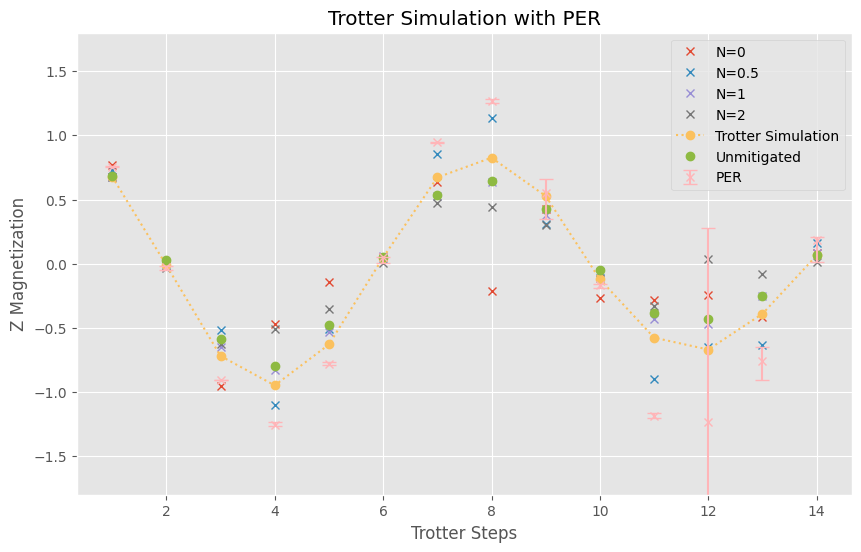

In [63]:
res = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= Aer.get_backend('qasm_simulator').run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    res.append(tot/(1024*n*2))

plt.figure(figsize=(10,6))
for i, noise in enumerate(list(circuit_results)[0].get_result(expectations[0]).get_strengths()):
    plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.errorbar(range(1,15), results, yerr=[[np.abs(res[1]) for res in results_errors],[np.abs(res[0]) for res in results_errors]],fmt='x', capsize=5, label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
plt.savefig("Trotter_Sim_PER.png")

Text(0, 0.5, 'Z Magnetization')

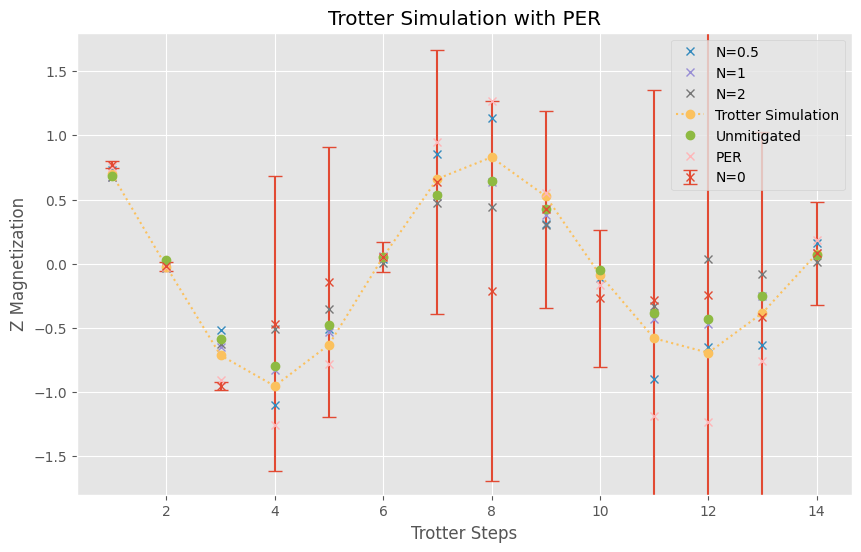

In [72]:
res = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= Aer.get_backend('qasm_simulator').run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    res.append(tot/(1024*n*2))

plt.figure(figsize=(10,6))
for i, noise in enumerate(list(circuit_results)[0].get_result(expectations[0]).get_strengths()):
    if noise == 0:
        plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt='x', yerr=[res[i] for res in results_at_noise_errors], capsize=5, label='N='+str(noise))
    else:
        plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
        
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.plot(range(1,15), results, 'x', label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
plt.savefig("Trotter_Sim_n_0.png")

Text(0, 0.5, 'Z Magnetization')

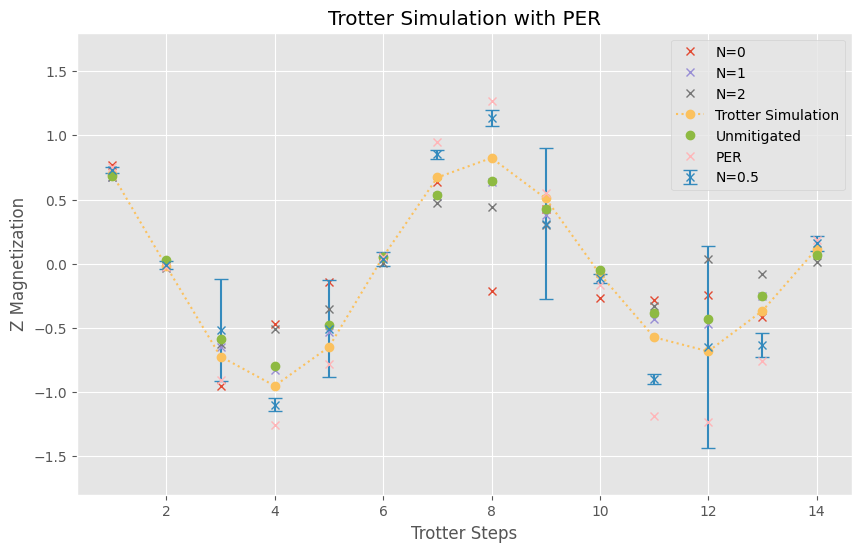

In [73]:
res = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= Aer.get_backend('qasm_simulator').run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    res.append(tot/(1024*n*2))

plt.figure(figsize=(10,6))
for i, noise in enumerate(list(circuit_results)[0].get_result(expectations[0]).get_strengths()):
    if noise == 0.5:
        plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt='x', yerr=[res[i] for res in results_at_noise_errors], label='N='+str(noise), capsize=5)
    else:
        plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
        
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.plot(range(1,15), results, 'x', label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
plt.savefig("Trotter_Sim_n_05.png")

Text(0.5, 1.0, 'Expectation vs Noise Strength IIIZ')

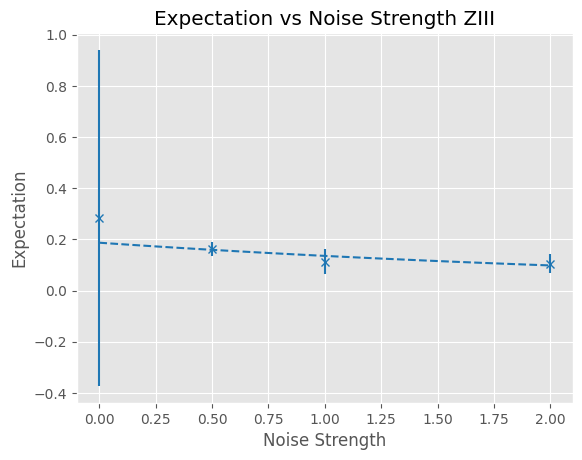

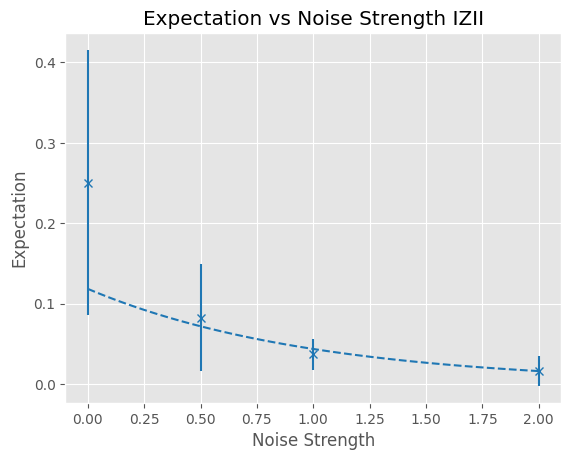

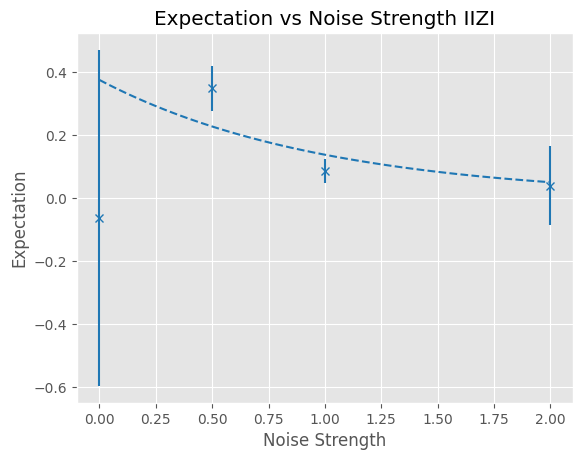

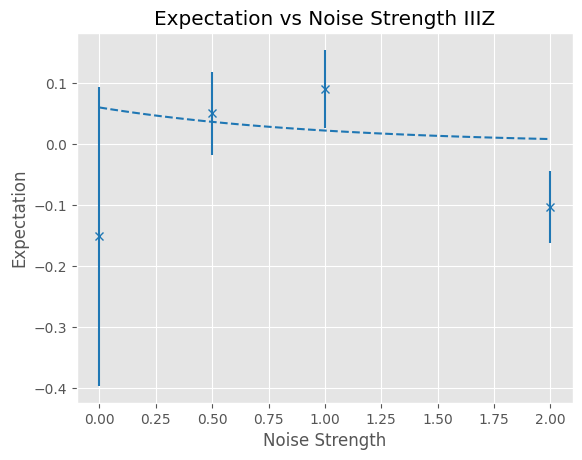

In [66]:
ax = circuit_results[-1].get_result("ZIIII").plot()
plt.title('Expectation vs Noise Strength ZIII')
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.savefig("Expectation_vs_Noise_Strength_ZIII.png")
circuit_results[-1].get_result("IZIII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IZII')
plt.savefig("Expectation_vs_Noise_Strength_IZII.png")
circuit_results[-1].get_result("IIZII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIZI')
plt.savefig("Expectation_vs_Noise_Strength_IIZI.png")
circuit_results[-1].get_result("IIIZI").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIIZ')
plt.savefig("Expectation_vs_Noise_Strength_IIIZ.png")

## Analysis

In [67]:
layer1 = experiment.analysis.get_layer_data(0)

<Axes: >

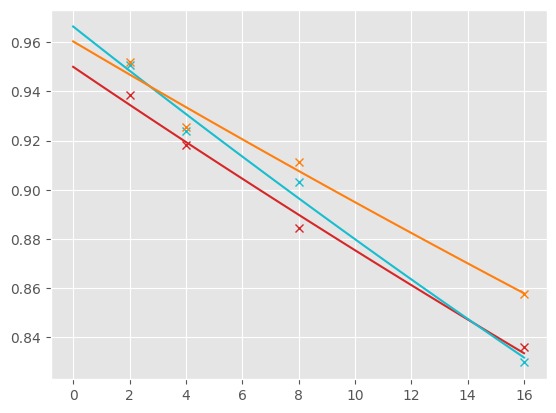

In [68]:
layer1.graph((1,))

<Axes: >

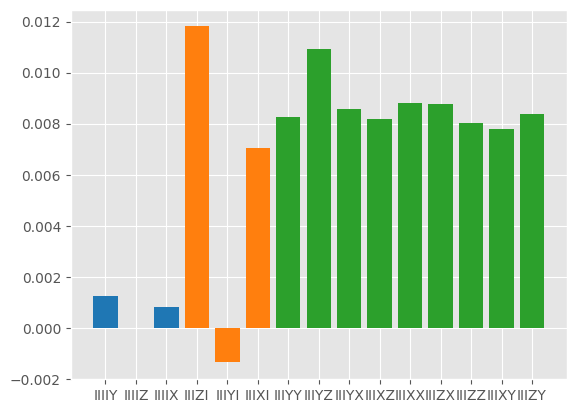

In [69]:
layer1.plot_infidelitites((0,),(1,),(0,1))

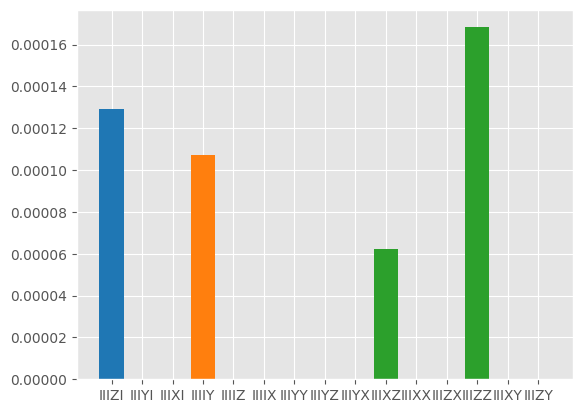

In [70]:
layer1.plot_coeffs((1,),(0,),(0,1))

In [71]:
import pickle
with open("graph.pickle", "wb") as f:
    pickle.dump(results, f)